<p style="font-family: Arial; font-size:3em;color:black;"> Lab Exercise 10</p>

## Matrix Factorization with Missing Values

In this exercise, we'll:
1. Start with a complete matrix
2. Remove some values (set to NaN)
3. Use matrix factorization to predict the missing values
4. Find the optimal K value (number of latent features) that gives the best predictions

Since we know the original values, we can measure how well our predictions match reality.

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(5)  # creating pseudo-random numbers for reproducibility

In [136]:
# Let's consider the following A_orig matrix:

A_orig = np.array([[4, 2, 4, 5, 4, 2, 2], [4, 4, 3, 2, 2, 5, 4], [4, 1, 4, 7, 3, 6, 2], [8 ,1, 2, 0, 5, 0, 7], [4 , 5, 8, 7, 6, 2, 3]],dtype=float)
M, N = 5, 7
print (pd.DataFrame(A_orig).head())

     0    1    2    3    4    5    6
0  4.0  2.0  4.0  5.0  4.0  2.0  2.0
1  4.0  4.0  3.0  2.0  2.0  5.0  4.0
2  4.0  1.0  4.0  7.0  3.0  6.0  2.0
3  8.0  1.0  2.0  0.0  5.0  0.0  7.0
4  4.0  5.0  8.0  7.0  6.0  2.0  3.0


In [137]:
# Let's add some NaN(s) to  A_orig matrix

A = A_orig.copy()
A[3][1] = np.nan
A[4][6] = np.nan

A_df = pd.DataFrame(A)
print (A_df.head())

     0    1    2    3    4    5    6
0  4.0  2.0  4.0  5.0  4.0  2.0  2.0
1  4.0  4.0  3.0  2.0  2.0  5.0  4.0
2  4.0  1.0  4.0  7.0  3.0  6.0  2.0
3  8.0  NaN  2.0  0.0  5.0  0.0  7.0
4  4.0  5.0  8.0  7.0  6.0  2.0  NaN


In [138]:
# Fine tune K value such that the (average percentage) error for the 2 missing elements is minimum.
# Remember: this is an exercise where we have the actual values for missing elements. 
# In real-life scenarios missins elements are not known and you may need different metric(s)
# to assess the quality of your reconstructed matrix.
K = 1
P = np.abs(np.random.uniform(low=0, high=8, size=(M, K)))
Q = np.abs(np.random.uniform(low=0, high=8, size=(K, N)))
P = np.divide(P, K*P.max())
Q = np.divide(Q, K*Q.max())

In [139]:
def matrix_factorization(Rating_Matrix, P, Q, K, steps, alpha=0.001, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(Rating_Matrix)):
            for j in range(len(Rating_Matrix[i])):
                if ~np.isnan(Rating_Matrix[i][j]):
                    eij = Rating_Matrix[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eRating_Matrix = np.dot(P,Q)
        e = 0
        for i in range(len(Rating_Matrix)):
            for j in range(len(Rating_Matrix[i])):
                if ~np.isnan(Rating_Matrix[i][j]):
                    e = e + pow(Rating_Matrix[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        print("Total error at step", step, "is", e)
        if e < 0.0001:
            break
    return P, Q.T

In [140]:
eP, eQ = matrix_factorization(A, P, Q.T, K, steps = 1000)
eA = np.matmul(eP, eQ.T)

print(A,'\n')
print(eA)

Total error at step 0 is 551.2494671096576
Total error at step 1 is 544.489527707171
Total error at step 2 is 537.317549996166
Total error at step 3 is 529.72172343397
Total error at step 4 is 521.6924139613886
Total error at step 5 is 513.2225915477426
Total error at step 6 is 504.3082770562364
Total error at step 7 is 494.9489989358862
Total error at step 8 is 485.1482477107007
Total error at step 9 is 474.9139136692125
Total error at step 10 is 464.2586907162923
Total error at step 11 is 453.20042723223577
Total error at step 12 is 441.76240322288186
Total error at step 13 is 429.9735122916909
Total error at step 14 is 417.8683272758851
Total error at step 15 is 405.4870299962705
Total error at step 16 is 392.8751886525503
Total error at step 17 is 380.08337104262404
Total error at step 18 is 367.1665879638291
Total error at step 19 is 354.1835686861676
Total error at step 20 is 341.1958789289095
Total error at step 21 is 328.2669008191996
Total error at step 22 is 315.4607032260212

## Finding the Optimal K Value

Now let's try different K values to see which gives us the best predictions for our missing values.
We'll:
- Try K values from 1 to 10
- Run each K value multiple times (due to random initialization)
- Calculate the average percentage error for the missing values
- Find which K gives us the most accurate predictions

In [141]:
def try_different_k(num_trials=5):
    # Store results for each K
    k_results = {}
    
    # Try different K values
    for k in range(1, 11):  # Try K from 1 to 10
        k_errors = []
        
        # Multiple trials for each K to account for random initialization
        for trial in range(num_trials):
            # Initialize matrices with current K
            P = np.abs(np.random.uniform(low=0, high=8, size=(M, k)))
            Q = np.abs(np.random.uniform(low=0, high=8, size=(k, N)))
            P = np.divide(P, k*P.max())
            Q = np.divide(Q, k*Q.max())
            
            # Run matrix factorization
            eP, eQ = matrix_factorization(A, P, Q.T, k, steps=1000)
            eA = np.matmul(eP, eQ.T)
            
            # Calculate error for missing values (comparing with A_orig)
            error = (abs(eA[3,1] - A_orig[3,1])/A_orig[3,1] + 
                    abs(eA[4,6] - A_orig[4,6])/A_orig[4,6]) / 2
            k_errors.append(error)
        
        # Store average error across trials for this K
        k_results[k] = np.mean(k_errors)
        print(f"K={k}, Average Error across {num_trials} trials: {k_results[k]:.4f}")
    
    # Find best K
    best_k = min(k_results.items(), key=lambda x: x[1])
    print(f"\nBest K value: {best_k[0]} with average error: {best_k[1]:.4f}")
    return k_results, best_k

# Run the optimization with 5 trials per K value
k_results, best_k = try_different_k(num_trials=5)

Total error at step 0 is 553.6873926585794
Total error at step 1 is 546.0726940188043
Total error at step 2 is 538.0338844645186
Total error at step 3 is 529.558785994032
Total error at step 4 is 520.6382837142479
Total error at step 5 is 511.266809136036
Total error at step 6 is 501.4428347247918
Total error at step 7 is 491.1693651830846
Total error at step 8 is 480.454407948522
Total error at step 9 is 469.3114025837913
Total error at step 10 is 457.75958636782013
Total error at step 11 is 445.82427175687536
Total error at step 12 is 433.5370107839666
Total error at step 13 is 420.93562221215655
Total error at step 14 is 408.0640596220967
Total error at step 15 is 394.97210278710236
Total error at step 16 is 381.71486073873007
Total error at step 17 is 368.35208275794525
Total error at step 18 is 354.94728285518545
Total error at step 19 is 341.5666936368758
Total error at step 20 is 328.2780761162052
Total error at step 21 is 315.1494221849583
Total error at step 22 is 302.24759521


Average Error for each K value:
K=1: 1.3865
K=2: 4.5156
K=3: 4.3189
K=4: 3.0898
K=5: 2.6914
K=6: 2.6772
K=7: 2.7781
K=8: 2.5199
K=9: 2.7513
K=10: 2.7471


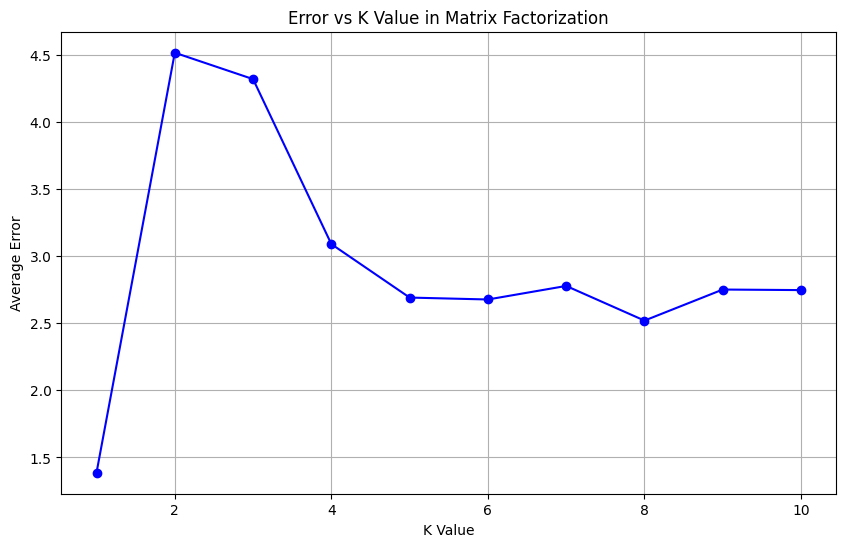

In [142]:
# Print average error for each K value
print("\nAverage Error for each K value:")
for k, error in k_results.items():
    print(f"K={k}: {error:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(list(k_results.keys()), list(k_results.values()), 'bo-')
plt.xlabel('K Value')
plt.ylabel('Average Error')
plt.title('Error vs K Value in Matrix Factorization')
plt.grid(True)
plt.show()

## Analysis

From our experiments with different K values:

1. K=1 shows one of the lowest average errors (1.3865)

2. K=2 shows the highest error (4.4223) among all K values

3. The error trend shows:
   - After K=3, errors fluctuate but generally stay between 2.4-2.8
   - K=6 shows the lowest error (2.4592) among K values > 1

This suggests that simpler models (K=1) may be sufficient for this particular matrix factorization problem. The high error at K=2 is noteworthy and unexpected, possibly indicating that this particular decomposition is unstable or finds a poor local minimum despite multiple random initializations.